# Bots on Twitter: Web & Society Seminar Project

_____________________________________
## Import Packages

In [1]:
# Import needed packages for data scraping
import pandas as pd
import json
import random
from geopy.geocoders import Nominatim
import time
import numpy as np
 
    
# Import needed packages for preprocessing
import nltk
import re
import string                    
import gensim
nltk.download('wordnet')
from sklearn import preprocessing
import preprocessor as pre
from langdetect import detect


# Import needed packages for clustering
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import umap
import hdbscan


# Import needed packages for vizualisations
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image 
import seaborn as sns


# Import needed packages for topic extraction
from sklearn.feature_extraction.text import CountVectorizer


# Import needed packages for clustering validation
from sklearn.metrics import silhouette_score


# Import needed packages for sentiment analysis
from flair.models import TextClassifier
from flair.data import Sentence


# Import package for saving data/embeddings
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


_____________________________________
## Data Scraping

In [2]:
# Loading the json files containing the data
with open('Twibot-20/train.json') as file:
    json_data_train = json.loads(file.read())
    
with open('Twibot-20/test.json') as file:                                                         
    json_data_test = json.loads(file.read())

with open('Twibot-20/dev.json') as file:
    json_data_dev = json.loads(file.read())

    
# Set a seed() to initialize a random number generator, enableing a possible replication of a random sampling of tweets in a later step   
random.seed(23)


def get_country(location: str, call = 1) -> str:
    '''
    This function tries to return for a given input string indicating a location on earth, 
    the country (as string) in which the respective location can be located. This is done by utilizing the
    Nominatim, a geocoder for OpenStreetMap data. Further the function can try to find the country information 
    for a respective string up to three times via a recursive call, if after the thrid call
    still no country code was retrieved the function returns NaN.
    '''
    
    # Seting function to sleep, so that the OpenStreetMap does not block calls
    time.sleep(1)
    
    # Check if the provided location is empty, if so return NaN. If the location is not empty try to retrive for the given input string the respective country string, when no country information 
    # get retrieved the function tries recursively finding the information up to three times, at the fourth time it returns NaN.
    if location != " ":
        try:
            # Instantiating a new Nominatim client
            geolocator = Nominatim(user_agent="geoapiCoordinates")
            
            # Trying to get geographic data from an address
            location_info = geolocator.geocode(location, exactly_one = True,language = "english", namedetails = True, addressdetails = True)
            # check parameters
            
            # Extracting found country information from the retrieved geographic data
            country = location_info.raw['address']['country_code']
            
            # Return country information
            return country
        
        except:
            # If try case is resultless the function calls itself recursively up to 3 times, at the fourth time NaN get returned
            if call == 4:
                return 'NaN'  
            else: 
                return get_country(location, call + 1)
    else: 
        return 'NaN'

    
def create_dataframe(json_data) -> pd.DataFrame:
    '''
    This function takes as input twitter json data which is in the format of the Twibot-20 data, and extracts the ID, self-defined location, country, label (bot or human), and recent tweets (up to 200)
    of a twitter user. All this information is then stored in a pandas dataframe, which gets returned by the function.
    '''
    
    # Creating empty lists to store the IDs, self-defined locations, countries, labels, and recent tweets of twitter users in
    ls_ID, ls_location, ls_country, ls_label, ls_tweets = [], [], [], [], []
    
    # Extracting the twitter profil id, the profile's country, the profile's label, and 20 random (or less if not more then 20 where produced) tweets from the json data
    for obj in json_data: 
        # Getting and appending twitter profil id to the list ls_ID
        ls_ID.append(obj['profile']['id'])
        
        # Getting and appending twitter location string to the list ls_location. If user did not provide this information NaN gets appended.
        if obj['profile']['location'] != ' ':
            ls_location.append(obj['profile']['location'])
        else:
            ls_location.append('NaN')
        
        # Getting from the location string if possible the user's country via applying the function get_country() and append it to the list ls_country. 
        # If the user did not provide any location information NaN gets appended.
        country = get_country(obj['profile']['location'])
        ls_country.append(country)
        
        # Getting and appending the user's label bot/no bot to the list ls_label
        ls_label.append(int(obj['label']))
        
        # Getting and appending 20 (or less) randomly selected tweets of the user to the list tweets_ls. If the user did not produce any tweets NaN gets appended.
        if isinstance(obj['tweet'], list):
            if len(obj['tweet']) > 20:
                tweets_all = obj['tweet']
                tweets_sampled = random.sample(tweets_all, 20)  
                ls_tweets.append(tweets_sampled)
            else:
                ls_tweets.append(obj['tweet'])                                                                   # if less 20 do we actually want it?
        else:
            ls_tweets.append('NaN')
    
    # Combine the lists ID_ls, location_ls, country_ls, label_ls, and tweets_ls, which contain the information of interest to a dataframe
    df = pd.DataFrame(list(zip(ls_ID, ls_location, ls_country, ls_label, ls_tweets)), columns=['ID', 'location', 'country', 'label', 'tweet'])
    
    # Return the created dataframe
    return df


# Applying the function create_dataframe() to the json data containg the twitter users (bot and humans) to create data frames including information about
# the IDs, self-defined locations, countries, labels (bot or human), and recent tweets (up to 200) of the users
df_train = create_dataframe(json_data_train)
df_test = create_dataframe(json_data_test)
df_dev = create_dataframe(json_data_dev)


# Binding the created dataframes by row to get one datframe containing all data
df = pd.concat([df_train, df_test, df_dev], ignore_index = True)  # put together


# Reducing the dataframe to tuples of selected english-speaking countries (us = United States, gb = Great Britain, au = Australia, nz = New Zealand)
countries = ['us', 'gb']
df = df[df.country.isin(countries)]
# df['tweet'].replace('', np.nan, inplace=True)                                                                # check if line is needed
print(df['country'].unique())


# Viewing the created dataframe superficially
print(df.head())                                                                                
print(df.shape)
print(df.dtypes)


# Saving data as a Pickle (serialize) object to file to load it later again
df.to_pickle('data.pkl') 

['us' 'gb']
            ID                 location country  label  \
0    17461978              Orlando, FL       us      0   
2    17685258                  Florida       us      0   
3    15750898                Tampa, FL       us      0   
4  1659167666   Jacksonville Beach, FL       us      1   
5    34743251            Hawthorne, CA       us      0   

                                               tweet  
0  [Electric Zoo was WILD 🐅🔥 @ElectricZoo https:/...  
2  [RT @DanScavino: https://t.co/pkNemLfES6\n, RT...  
3  [RT @PaulFox13: Tonight's 8:00 pm sunset is th...  
4  [RT @jamesbuffyboyle: this is my friend Davis,...  
5  [Falcon 9 lands on Just Read the Instructions ...  
(4862, 5)
ID          object
location    object
country     object
label        int64
tweet       object
dtype: object


_____________________________________
## Preprocessing and Extraction of Embeddings via BERT

In [46]:
# Loading the created dataframe
df = pd.read_pickle('data.pkl') 


# Splitting the dataframe into two dataframes, one for bots, and one for humans
df_bots = df[df['label'] == 1]
df_no_bots = df[df['label'] == 0]


# Exploding the two dataframes by their column tweet. This means for every user in the dataframes multiple rows get created, depending on the number of tweets (at max 20) that are 
# saved for the respective user, where each row containing in the column tweet now just one tweet.
df_bots = df_bots.explode('tweet')
df_no_bots = df_no_bots.explode('tweet')                                                  


# Viewing the two created dataframes superficially, and getting the frequency of bots and valid users
print(df_bots.head())
print(df_bots.shape)
print(df_bots.dtypes)
print(df_bots['ID'].nunique())     # frequency 

print(df_no_bots.head())
print(df_no_bots.shape)
print(df_no_bots.dtypes)
print(df_no_bots['ID'].nunique())   # frequency 

            ID                 location country  label  \
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   

                                               tweet  
4  RT @jamesbuffyboyle: this is my friend Davis, ...  
4  The wind just hit me and whispered “fuck dat l...  
4  When you begging your mom to let you stay over...  
4  RT @BrentPaterson94: @VonteThePlugNC 🔥🔥🔥🔥🔥 no 🧢\n  
4  I’m the illest up &amp; Coming outta Carolina ...  
(2399, 5)
ID          object
location    object
country     object
label        int64
tweet       object
dtype: object
124
          ID      location country  label  \
0  17461978   Orlando, FL       us      0   
0  17461978   Orlando, FL       us      0   
0  17461978   Orlando, FL       us      0   
0  17461978   Orla

### Preprocessing via Functions

In [5]:
def remove_links(tweet: str) -> str:
    '''
    Function takes a tweet and removes http, bitly links from it. Afterwards returning the tweet string.
    '''
    
    # Removing http links
    tweet = re.sub(r'http\S+', '', tweet)   
    
    # Removing bitly links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  
    
    # Removing link mentioning 
    tweet = tweet.strip('[link]')   # remove [links]
    
    # Removing links to pictures
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    
    # Returning tweet without link mentions
    return tweet


def remove_audiovisual(tweet: str) -> str:
    '''
    This function takes a tweet and removes videos and audio tags or labels. Afterwards returning the cleaned tweet.
    '''
    
    # Removing 'VIDEO:' from start of a tweet
    tweet = re.sub('VIDEO:', '', tweet)  
    
    # Removing 'AUDIO:' from start of a tweet
    tweet = re.sub('AUDIO:', '', tweet)  
    
    # Returning tweet without videos and audio tags or labels
    return tweet


def nlp_preprocess(tweets: pd.Series) -> list:
    ''' 
    This NLP function cleans tweets so that they resemble sentences used in the daily language, thus for further analysis no tweet specific trained models are necessray to use. 
    '''
    
    # Creating an empty list to fill with preprocessed tweets
    tweets_preprocessed = []

    for tweet in tweets:
        # Removing urls, hashtags, mentions, reserved words (RT, FAV), emojis, and smileys
        tweet = pre.clean(tweet)
        
        # Applying predefined functions for tweet cleaning
        tweet = remove_links(tweet)
        tweet = remove_audiovisual(tweet)
        
        # Removing number mentionings
        tweet = re.sub('([0-9]+)', '', tweet)  
        
        # Removing words containing numbers
        tweet = re.sub('\w*\d\w*', '', tweet)  
        
        # Removing line break 
        tweet = re.sub('\n', '', tweet)
        
        # Strip punctuation special to tweets, but uncommon in natural language sentences
        punctuation = '"$%&\'*+:;/()<=>[\\]^_`{|}~•@£'
        tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  
        
        # Removing double/multiple spacing
        tweet = re.sub('\s+', ' ', tweet)   
        
        # Normalize characters, means concretly --> todaaaaay = today
        tweet = re.sub(r'([A-Za-z])\1{2,}', r'\1', tweet) 
        
        # Appending preprocessed tweet to the list tweets_preprocessed. If tweet now empty append NaN
        if tweet != '' and tweet != ' ':
            tweets_preprocessed.append(tweet)
        else:
            tweets_preprocessed.append('NaN') 
    
    # Returning list of processed tweets
    return tweets_preprocessed


# Applying nlp_preprocess() function to the tweets column to preprocess the data for further analysis
df_bots['tweet'] = nlp_preprocess(df_bots['tweet'])                                                       
df_no_bots['tweet'] = nlp_preprocess(df_no_bots['tweet']) 

In [ ]:
def detect_english(tweets: pd.Series) -> list:
    ''' 
    This function detects if the language of an tweet given via a pd.Series is english or not, after removing punctuations and lowering it to prevent that
    for instance doubling of exclamation marks lead to a non-english detection although the tweets is english. Afterwards the function returns a list either 
    containg a respective tweet if the tweet is english or NaN instead if the tweet was not identified as english. Attention: The function works not optimal for 
    english detection of sentences containg just up to two or three words, as these are typically grammatically no sentences.
    '''
    
    # Creating an empty list to fill with english tweets or NaN
    english_tweets = []
    
    # Trying to check if a given tweet is in english and if so append it to the list. If its is not in english
    # or an exception is raised append NaN.
    for tweet in tweets:
        tweet_wp = tweet.translate(str.maketrans('', '', string.punctuation))
        tweet_wp_lo = tweet_wp.lower()
        
        try: 
            if detect(tweet_wp_lo)=='en':
                english_tweets.append(tweet)
            else:
                english_tweets.append('NaN')
        except:
            english_tweets.append('NaN')
        
    # Returning list of tweets, indicating if the tweet are in english or not (or not retrievable)
    return english_tweets


# Applying english_check() function to the tweets column to return the tweets that are english
df_bots['tweet'] = detect_english(df_bots['tweet'])
df_no_bots['tweet'] = detect_english(df_no_bots['tweet'])     # problems with words, good with sentnces

In [44]:
# Reducing dataframes to tweets with actual content (bots/users that posted any tweets, bots/users that posted tweets with content not reduced due preprocessing, tweets that are in english)
df_bots = df_bots.loc[df_bots['tweet'] != 'NaN', :]                                                      
df_no_bots = df_no_bots.loc[df_no_bots['tweet'] != 'NaN', :]


# Viewing the two created dataframes superficially after preprocessing, and getting the frequency of bots and valid users
print(df_bots.head())
print(df_bots.shape)
print(df_bots.dtypes)
print(df_bots['ID'].nunique())     # frequency 

print(df_no_bots.head())
print(df_no_bots.shape)
print(df_no_bots.dtypes)
print(df_no_bots['ID'].nunique())   # frequency 

            ID                 location country  label  \
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   
4  1659167666   Jacksonville Beach, FL       us      1   

                                               tweet  
4   this is my friend Davis, her costume was and ...  
4  The wind just hit me and whispered fuck dat li...  
4  When you begging your mom to let you stay over...  
4  Im the illest up amp Coming outta Carolina cat...  
4   Ima gone head and say it if a girl Im attract...  
(46514, 5)
ID          object
location    object
country     object
label        int64
tweet       object
dtype: object
2809
          ID      location country  label  \
0  17461978   Orlando, FL       us      0   
0  17461978   Orlando, FL       us      0   
0  17461978   Orlando, FL       us      0   
0  17461978   Or

### Get embeddings via BERT (reduced via UMAP)

In [3]:
def get_embeddings(tweets: pd.Series) -> list:
    '''
    This function takes as input an pandas series containing twetts of twitter users. Based on these tweets embeddings are created and extracted via the application of a BERT model. 
    The output of the function is a list of sentence, here tweet, embeddings.
    '''
    
    # Implementing a BERT model, here using all-mpnet-base-v2 as it is an all-round model tuned for many use-cases, which is trained on 
    # a large and diverse dataset of over 1 billion training pairs. See also 'https://huggingface.co/sentence-transformers/all-mpnet-base-v2'.
    model = SentenceTransformer('all-mpnet-base-v2')
    
    # Creating empty list to store the retrieved embeddings in
    ls_embeddings = []
    
    # Extracting the embeddings
    for tweet in tweets:                                                                               # not sure what gets assigned if we preprocessed the tweet to empty, if we need a NaN condition or not
        embedding = model.encode(tweet)
        ls_embeddings.append(embedding)
            
    # Returning the list with embeddings
    return ls_embeddings 


# Extracting embeddings for the bot tweets (with and without preprocessing) and append them as new column to the dataframe
# Embedding extraction without preprocessing    
embeddings_bots = get_embeddings(df_bots['tweet'])
df_bots['embeddings'] = embeddings_bots


# Extracting embeddings for the human tweets (with and without preprocessing) and append them as new column to the dataframe
# Embedding extraction without preprocessing    
embeddings_no_bots = get_embeddings(df_no_bots['tweet'])
df_no_bots['embeddings'] = embeddings_no_bots

In [32]:
def get_umap_embeddings(embeddings: list, neighbors: int, components:int) -> np.ndarray:           
    '''
    This function takes a list containing embeddings as input and reduce the embeddings in dimensionality,
    more precise in the given case form a dimension of 768 to the input parameter components, by applying UMAP. 
    UMAP is a general purpose manifold learning and dimension reduction algorithm. Afterwards the function returns
    the in dimensionality reduced embeddings. Further the function takes 
    an integer value as input, that determines local neighborhood parameter of UMAP.
    '''
    
    # Applying UMAP to reduce the high-dimensional inputted embeddings to lower dimensionality. 
    # Here the dimensionality of 768 is reduced to 10 while keeping the size of the local neighborhood at 15. 
    umap_embeddings = umap.UMAP(n_neighbors=neighbors,                                                                      
                                n_components=components,                                                                   
                                min_dist=0.0, 
                                metric='cosine').fit_transform(embeddings)
    
    # Return the in dimensionality reduced embeddings
    return umap_embeddings


# Applying the function get_umap_embeddings() to reduce the retrieved embeddings to five dimensions with the metric consine to make normalization of embeddinngs not necessary,
# and append them as columns to the dataframes
umap_embeddings_bots = get_umap_embeddings(embeddings_bots, 15, 5)
df_bots['UMAP5 embeddings'] = umap_embeddings_bots.tolist() 

umap_embeddings_no_bots = get_umap_embeddings(embeddings_no_bots, 15, 5)   
df_no_bots['UMAP5 embeddings'] = umap_embeddings_no_bots.tolist()

# Reducing the data to two dimensions to visualize it, and append them as columns to the respective dataframes
umap_embeddings2dim_bots = get_umap_embeddings(embeddings_bots, 15, 2)
df_bots['UMAP2 embeddings'] = umap_embeddings2dim_bots.tolist() 

umap_embeddings2dim_no_bots = get_umap_embeddings(embeddings_no_bots, 15, 2)   
df_no_bots['UMAP2 embeddings'] = umap_embeddings2dim_no_bots.tolist() 

#### Vizualise the data 

Text(0.5, 1.0, 'Valid User Data')

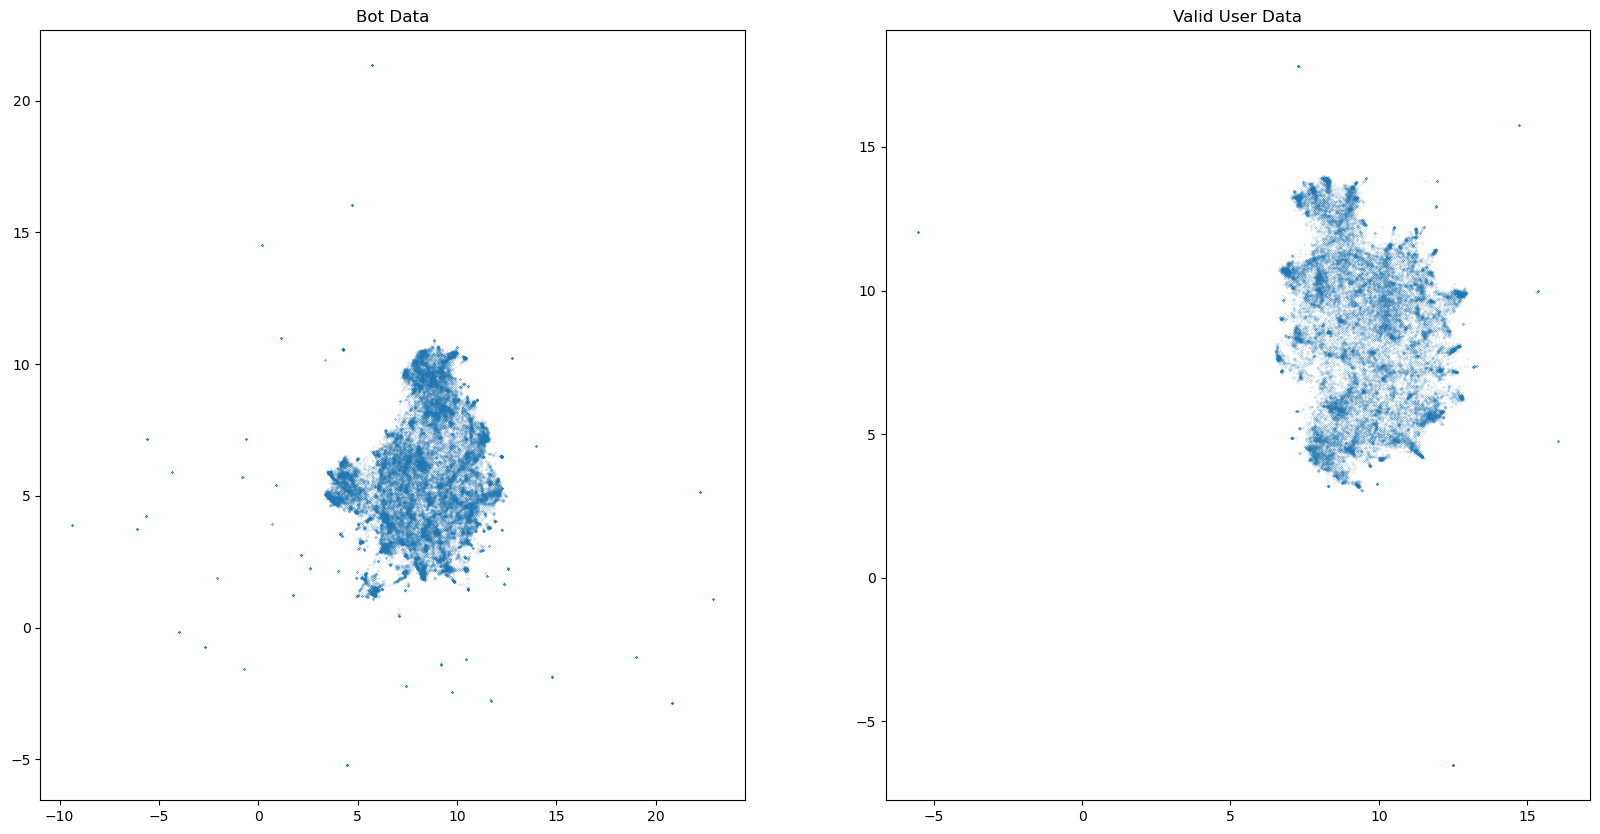

In [37]:
data_bots = pd.DataFrame(umap_embeddings2dim_bots, columns=['X', 'Y'])
data_no_bots = pd.DataFrame(umap_embeddings2dim_no_bots, columns=['X', 'Y'])


# Visualize bot and human data
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))                                                     
ax1.scatter(data_bots['X'], data_bots['Y'], s = 0.01)
ax1.set_title('Bot Data')

ax2.scatter(data_no_bots['X'], data_no_bots['Y'], s = 0.01)
ax2.set_title('Valid User Data')

_____________________________________
## Clustering of the tweets

### K-Means

In [6]:
def get_kmeans_clustering(embeddings: np.ndarray, k: int) -> np.ndarray:
    '''
    This function gets as input an list containing embeddings and then applies k-means clustering to them by selecting as second input parameter an respective k. 
    Afterwards, the function returns the clustering of the embeddings.
    '''
    
    # Initializing k-Means model
    clustering = KMeans(init="random",
                        n_clusters = k,
                        n_init=10,             # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
                        max_iter=300,          # sets the number of maximum iterations for each initialization of the k-means algorithm.
                        random_state=23)       # Determines random number generation for centroid initialization. Use an int to make the randomness deterministic. See Glossary.                     
    
    # Fitting the k-Means model to the data and predicting the clusters
    fit = clustering.fit(embeddings)                                             # maybe embeddings to list if not working                                                        
    predict = clustering.predict(embeddings)
    
    # Returning the clustering
    return clustering

#### Select a good k for K-Means

In [7]:
def get_average_silhouette_coefficients_per_k(embeddings: list, k_upper: int) -> list:
    '''
    This function gets as input an list containing embeddings and then applies k-means clustering to them 
    for different k's. More precise the second input parameter gives an upper limit for k.
    The function calculates based on each clustering the respective average silhouette coefficient 
    and afterwards returns a list of average silhouette coefficients. 
    '''
    
    # A list holds the silhouette coefficients for each k
    ls_silhouette_coefficients = []
    
    # Calculating the silhouette coefficient for k=l different k-means clustering and each time append it to the list ls_silhouette_coefficients
    for k in range(2, k_upper):
        kmeans = get_kmeans_clustering(embeddings, k)
        score = silhouette_score(embeddings, kmeans.labels_)
        ls_silhouette_coefficients.append(score)
    
    # Returning the list of silhouette coefficients
    return ls_silhouette_coefficients
    

# Applying the function get_average_silhouette_coefficients_per_k() to calculate the average silhouette coefficient for different k-means clustering results, differing in k
average_silhouette_coefficients_bots = get_average_silhouette_coefficients_per_k(umap_embeddings_bots, 20)
average_silhouette_coefficients_no_bots = get_average_silhouette_coefficients_per_k(umap_embeddings_no_bots, 20)

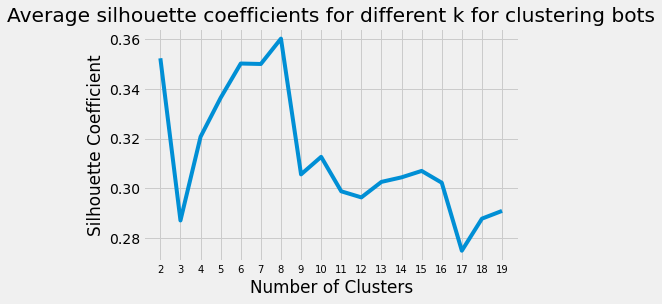

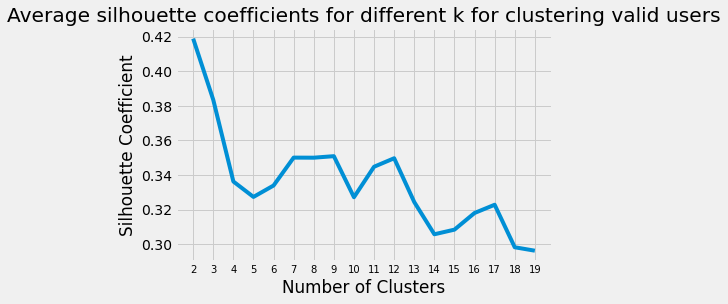

In [8]:
# Visualizing the average silhouette coefficient for k-means clustering results for differnt k to find the best k
plt.style.use('fivethirtyeight')
plt.plot(range(2, 20), average_silhouette_coefficients_bots)
plt.xticks(range(2, 20), fontsize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Average silhouette coefficients for different k for clustering bots')
plt.show()

plt.plot(range(2, 20), average_silhouette_coefficients_no_bots)
plt.xticks(range(2, 20), fontsize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Average silhouette coefficients for different k for clustering valid users')           
plt.show()

#### Clustering K-Means

In [8]:
# Applying the function get_kmeans_clustering() to get clustering of the data based on the in dimensionality reduced embeddings
kmeans_bots = get_kmeans_clustering(umap_embeddings_bots, 2)
kmeans_no_bots = get_kmeans_clustering(umap_embeddings_no_bots, 2)


# Appending cluster labels of tupels as a new column to the dataframes
df_bots['clustering K-Means'] = kmeans_bots.labels_ 
df_no_bots['clustering K-Means'] = kmeans_no_bots.labels_ 


# Extract tupels by cluster for the twitter bots
cluster_1_bots = df_bots[df_bots['clustering K-Means'] == 0] 
cluster_2_bots  = df_bots[df_bots['clustering K-Means'] == 1] 


# Extract tupels by cluster for the valid twitter users
cluster_1_no_bots = df_no_bots[df_no_bots['clustering K-Means'] == 0] 
cluster_2_no_bots  = df_no_bots[df_no_bots['clustering K-Means'] == 1] 

##### Vizualising K-Means Clusters with Wordclouds

In [2]:
def transform(val: int) -> int:
    '''
    This function transforms mask with a 0 and 1 format to act as shape for a wordcloud. 
    Means it changes black values of 0 to 1 back, as this is the black part requirement for the mask.
    White parts should encoded by 255, but stay untouched by this function.
    '''
    
    if val == 0:
        return 1
    else:
        return val


# Loading a mask determining the shape of the following wordclods    
twitter_mask = np.array(Image.open('twitter-logo.png'))                                # available at https://www.onlinewebfonts.com/icon/182709

# Transforming mask by applying the function transform_format() to each value in each row of the previous mask
for i in range(len(twitter_mask)):
    for j in range(len(twitter_mask[i])):
        for k in range(len(twitter_mask[i][j])):
            twitter_mask[i][j][k] = transform(twitter_mask[i][j][k])
    
    
# Checking the resulting mask
twitter_mask

array([[[255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        ...,
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1]],

       [[255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        ...,
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1]],

       [[255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        ...,
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1]],

       ...,

       [[255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        ...,
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1]],

       [[255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        ...,
        [255, 255, 255,   1],
        [255, 255, 255,   1],
        [255, 255, 255,   1]],

       [[255

##### Wordclouds Bot Clusters

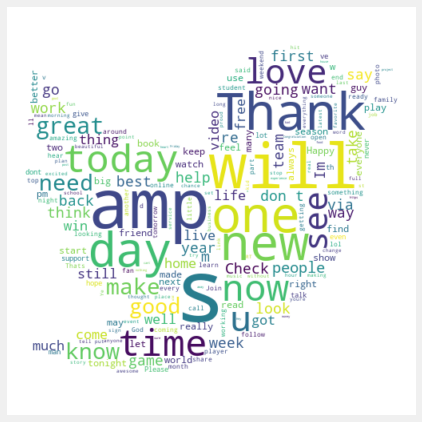

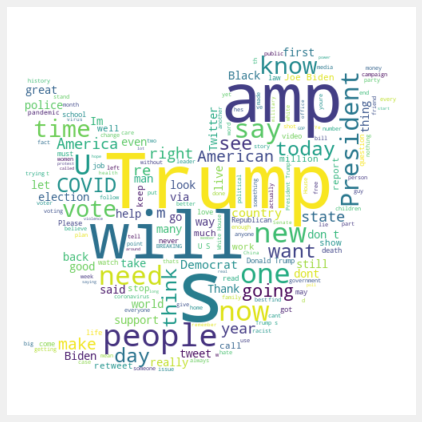

In [10]:
# Vizualising the first bots cluster with a wordcloud
all_words = ' '.join([text for text in cluster_1_bots['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110, mask=twitter_mask).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# Vizualising the second bots cluster with a wordcloud
all_words = ' '.join([text for text in cluster_2_bots['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110, mask=twitter_mask).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### Wordclouds Valid User Clusters

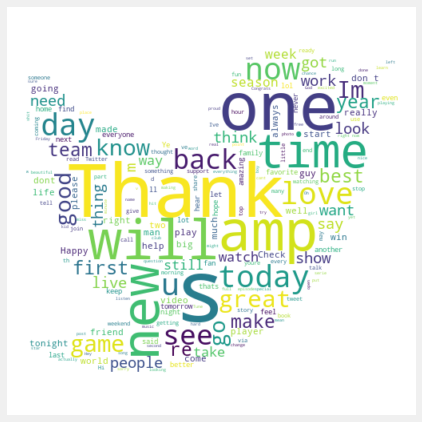

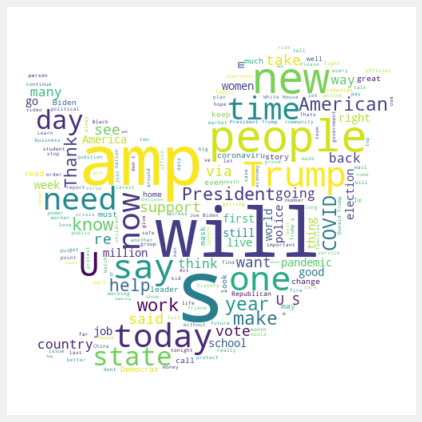

In [11]:
# Vizualising the first human cluster with a wordcloud
all_words = ' '.join([text for text in cluster_1_no_bots['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110, mask=twitter_mask).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# Vizualising the second human cluster with a wordcloud
all_words = ' '.join([text for text in cluster_2_no_bots['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110, mask=twitter_mask).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [12]:
def get_n_cluster_sizes(df: pd.DataFrame, n:int, cluster_column:str):
    '''
    This function returns the n (or less if n is bigger then the number of clusters) biggest clusters in terms of tweets for a given dataframe, if as input is a dataframe provided and respective column indicating the 
    clustering is stated. Further the integer value for n needs to be given as input
    '''
    
    # Grouping dataframe by cluster and counting the number of tweets per cluster. Further renaming the resulting columns of the 
    # new dataframe to clusters and size, and sort its entries in decreasing order.
    cluster_sizes = (df.groupby([cluster_column])
                    .tweet
                    .count()
                    .reset_index()
                    .rename({cluster_column: 'Cluster', 'tweet': 'Size'}, axis='columns')
                    .sort_values('Size', ascending=False))
    
    # Returning the whole created dataframe stating the cluster sizes, if more clusters want to be retrieved than actually can be found in the data,
    # or return a dataframe stating the sizes of the n biggest clusters.
    if (n+1) > len(df.index):
        return cluster_sizes
    else: 
        cluster_sizes = cluster_sizes.iloc[:(n+1), :]
        return cluster_sizes 

    
# Applying the function get_n_cluster_sizes() to get the sizes of the k-means clusters
print(get_n_cluster_sizes(df_bots, 2, 'clustering K-Means'))
print(get_n_cluster_sizes(df_no_bots, 2, 'clustering K-Means'))

   Cluster   Size
0        0  30914
1        1  15600
   Cluster   Size
0        0  21097
1        1  12929


### HDBSCAN

In [3]:
def get_HDBSCAN_clustering(embeddings: np.ndarray, min_size) -> np.ndarray:
    '''
    This function takes embeddings (reduced in demensionality via UMAP) and applies the clustering algorithm 
    HDBSCAN to them, to output clustering results. Further the function takes 
    an integer value as input, that and determines the minimum cluster size parameter of HDBSCAN. 
    HDBSCAN performs DBSCAN over varying epsilon values and integrates the result to find a clustering 
    that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities 
    (unlike DBSCAN), and be more robust to parameter selection.
    '''
    
    # Clustering inputted embeddings (of lower dimensionality due UMAP) with HDBSCAN
    clustering = hdbscan.HDBSCAN(min_cluster_size=min_size,                                                            
                                 metric='euclidean',
                                 algorithm = 'best',
                                 cluster_selection_method='eom',
                                 gen_min_span_tree=True).fit(embeddings)
    
    # Return the clustering results
    return clustering

#### Select a good minimum cluster size for HDBSCAN

In [4]:
# https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970
# https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf
# https://stackoverflow.com/questions/57377594/how-to-evaluate-hdbscan-text-clusters
def get_relative_validity_per_min_cluster_size(embeddings:list, min_size_upper:int) -> list:
    '''
    This function gets as input an list containing embeddings and then applies HDBSCAN clustering 
    to them for differnt minimum cluster sizes. More precise the second input parameter gives an upper limit for the 
    try out minimum cluster sizes. The function calculates based on each clustering a fast approximation of the 
    Density Based Cluster Validity (DBCV) score and afterwards returns a list of the scores.  
    This score might not be an objective measure of the goodness of clusterering, but can be used to 
    compare results across different choices of hyper-parameters.
    '''
    
    # A list holds the relative validity for each min cluster size
    ls_relative_validity = []
    
    for min_size in range(2, min_size_upper):
        hdbscan = get_HDBSCAN_clustering(embeddings, min_size)
        relative_validity = hdbscan.relative_validity_
        ls_relative_validity.append(relative_validity)
    
    # Returning the list containing the relative validity scores
    return ls_relative_validity


# Applying the function get_relative_validity_per_min_cluster_size() to calculate the relative validity for different HDBSCAN clustering results, differing in their minimum cluster size
relative_validities_bots = get_relative_validity_per_min_cluster_size(umap_embeddings_bots, 20)
relative_validities_no_bots = get_relative_validity_per_min_cluster_size(umap_embeddings_no_bots, 20)

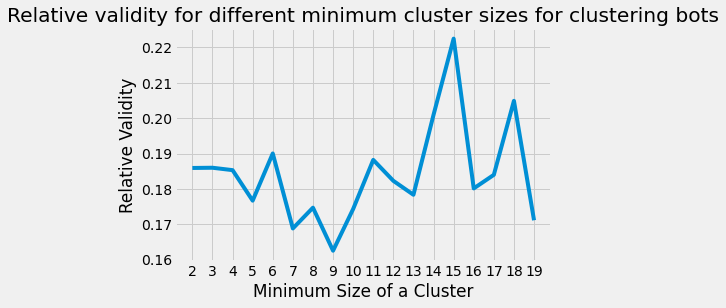

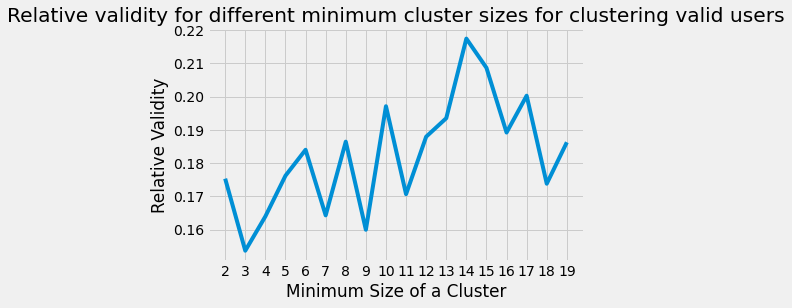

In [5]:
# Visualizing the relative validity for HDBSCAN clustering results for differnt minimum cluster sizes to find the best cluster size
plt.style.use('fivethirtyeight')
plt.plot(range(2, 20), relative_validities_bots)
plt.xticks(range(2, 20))
plt.xlabel('Minimum Size of a Cluster')
plt.ylabel('Relative Validity')
plt.title('Relative validity for different minimum cluster sizes for clustering bots')
plt.show()

plt.plot(range(2, 20), relative_validities_no_bots)
plt.xticks(range(2, 20))
plt.xlabel('Minimum Size of a Cluster')
plt.ylabel('Relative Validity')
plt.title('Relative validity for different minimum cluster sizes for clustering valid users')
plt.show()              

#### Clustering HDBSCAN

In [17]:
# Applying the function get_HDBSCAN_clustering() to get clustering of the data based on the in dimensionality reduced embeddings
hdbscan_bots = get_HDBSCAN_clustering(umap_embeddings_bots, 15)
hdbscan_no_bots = get_HDBSCAN_clustering(umap_embeddings_no_bots, 14)


# Appending cluster labels of tupels as a new column to the dataframes
df_bots['clustering HDBSCAN'] = hdbscan_bots.labels_  
df_no_bots['clustering HDBSCAN'] = hdbscan_no_bots.labels_ 

##### Vizualising HDBSCAN Clusters with Scatterplots

In [19]:
# Creating dataframes containing x and y coordiantes of the embeddings reduced to two dimension and the HDBSCAN clustering results of the tweets to enable cluster visualization
result_bots = pd.DataFrame(umap_embeddings2dim_bots, columns=['X', 'Y'])
result_bots['labels'] = hdbscan_bots.labels_

result_no_bots = pd.DataFrame(umap_embeddings2dim_no_bots, columns=['X', 'Y'])
result_no_bots['labels'] = hdbscan_no_bots.labels_      

##### Vizualising Bot vs Valid User Clusters

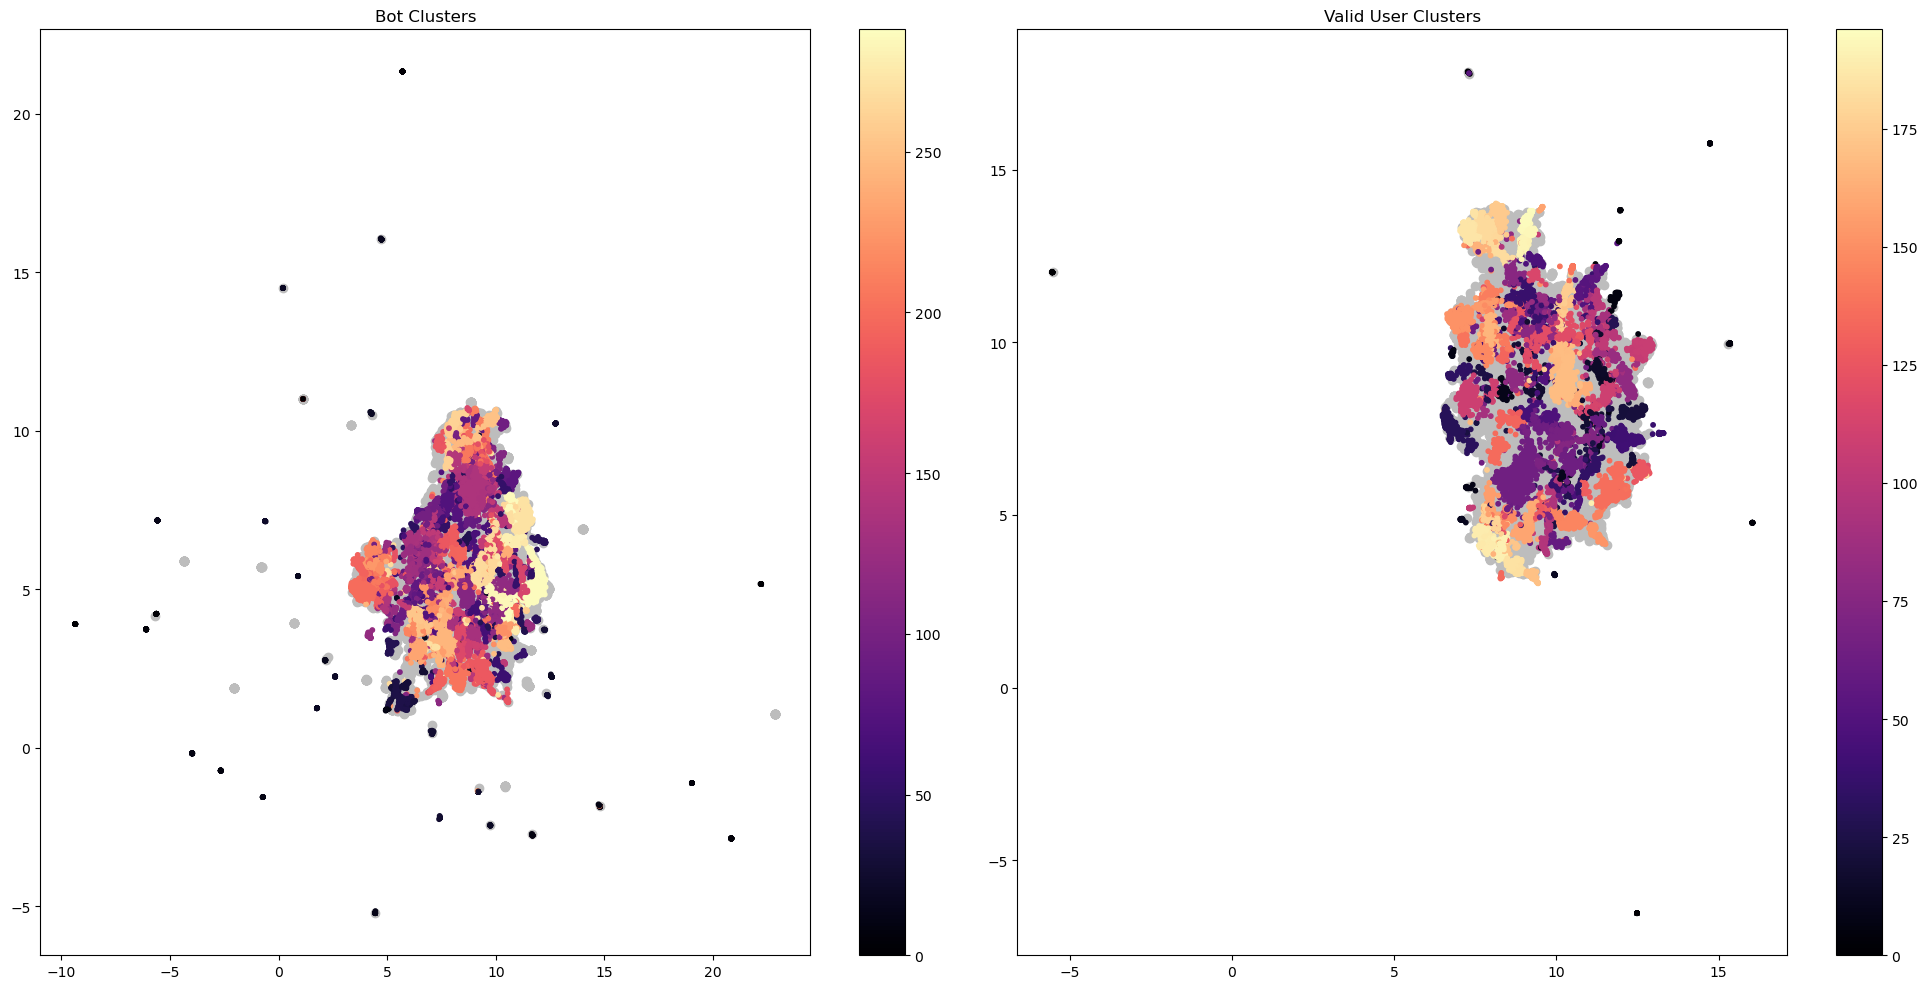

In [42]:
# Visualize clustering difference bots and humans
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10)) 
outliers_bots = result_bots.loc[result_bots['labels'] == -1, :]
clustered_bots = result_bots.loc[result_bots['labels'] != -1, :]                                                      
ax1.scatter(outliers_bots['X'], outliers_bots['Y'], color='#BDBDBD')
mappable1 = ax1.scatter(clustered_bots['X'], clustered_bots['Y'], c=clustered_bots['labels'], cmap='magma', s = 10)
ax1.set_title('Bot Clusters')
plt.colorbar(mappable1, ax = ax1)

outliers_no_bots = result_no_bots.loc[result_no_bots['labels'] == -1, :]
clustered_no_bots = result_no_bots.loc[result_no_bots['labels'] != -1, :]
ax2.scatter(outliers_no_bots['X'], outliers_no_bots['Y'], color='#BDBDBD')
mappable2 = ax2.scatter(clustered_no_bots['X'], clustered_no_bots['Y'], c=clustered_no_bots['labels'], cmap='magma', s = 10)
ax2.set_title('Valid User Clusters')
plt.colorbar(mappable2, ax = ax2)

plt.tight_layout()

In [22]:
# Applying the function get_n_cluster_sizes() to get the sizes of the ten biggest HDBSCAN clusters
print(get_n_cluster_sizes(df_bots, 10, 'clustering HDBSCAN'))
print(get_n_cluster_sizes(df_no_bots, 10, 'clustering HDBSCAN'))

     Cluster   Size
0         -1  24078
139      138   1487
205      204    939
272      271    898
201      200    854
287      286    687
234      233    576
187      186    504
194      193    397
255      254    383
111      110    343
     Cluster   Size
0         -1  17857
66        65   1281
138      137    659
152      151    619
170      169    547
109      108    447
108      107    434
175      174    434
187      186    362
182      181    356
31        30    294


#### Vizualising Topics of HDBSCAN Clusters 

In [23]:
# Followed instructions from https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
def create_documents(df: pd.DataFrame):
    '''
    For a given dataframe, this function creats a single document for each cluster of documents, here tweets, produced by HDBSCAN. Further it returns a dataframe containing 
    all the documents, here tweets, their respective clustering and a document index. The last output is the integer count of the number of documents, here tweets, in the data.
    '''
    
    # Constructing a dataframe containg all tweets, now viewed as documents, and the constructed HDBSCAN clustering now viewed as topics
    df_docs = df.loc[:, ['tweet', 'clustering HDBSCAN']]
    df_docs.columns = ['Doc', 'Topic']
    
    # Appending as a new column to the dataframe a count index
    df_docs['Doc_ID'] = range(len(df_docs))
    
    # Creating a single document for each cluster of documents, by joining all documents in a cluster together
    docs_per_topic = df_docs.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    # Retrieving the total length of documents 
    length = len(df['tweet'].tolist())
    
    # Returning the single documents, the created dataframe, and the length of the documents
    return docs_per_topic, df_docs, length
    

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    '''
    This function creates class-based TF-IDF vectors, based on the function c-TF-IDF_i=(t_i/w_i)*log(m/sum(t_j)).
    Also see https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6.
    '''
    
    # Frequency of each word t is extracted for each class i and divided by the total number of words w, to regularies frequent words in the class
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)                                                                              # here sometimes an error occures, do not ask me why.. it still gives results
    
    # The total, unjoined, number of documents m is divided by the total frequency of word t across all classes n
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    # Returning the class-based TF-IDF vectors and a vector of term/token counts
    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    '''
    When inputting class-based TF-IDF vectors, a vector of term/token counts and a single document for each cluster of documents, this function returns per default the top 20 
    words per topic based on their c-TF-IDF scores. The higher the score, the more representative the word should be of its topic.
    '''
    
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    
    # Returning the top 20 words per topic based on their c-TF-IDF scores
    return top_n_words


def extract_topic_sizes(df):
    '''
    This function gives the size of each topic, means the size of a cluster, for a given dataframe.
    '''
    
    # Grouping the dataframe by the column Topic, which indicates a cluster and counting the cluster sizes. These cluster sizes
    # are then saved in downsampled dataframe.
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({'Topic': 'Topic', 'Doc': 'Size'}, axis='columns')
                     .sort_values('Size', ascending=False))
    
    # Returning a datframe indicating the size of each topic 
    return topic_sizes


# Applying the function create_documents() to create a single document for each cluster of documents
docs_per_topic_bots, df_docs_bots, length_bots = create_documents(df_bots)
docs_per_topic_no_bots, df_docs_no_bots, length_no_bots = create_documents(df_no_bots)


# Applying the function c_tf_idf() to retrieve class-based TF-IDF vectors, means ab importance value for each word in a cluster which can be used to create a topic
tf_idf_bots, count_bots = c_tf_idf(docs_per_topic_bots.Doc.values, length_bots)
tf_idf_no_bots, count_no_bots = c_tf_idf(docs_per_topic_no_bots.Doc.values, length_no_bots)


# Applying the function extract_top_n_words_per_topic() to get the the top 20 words per topic based on their c-TF-IDF scores
top_n_words_bots = extract_top_n_words_per_topic(tf_idf_bots, count_bots, docs_per_topic_bots)
top_n_words_no_bots = extract_top_n_words_per_topic(tf_idf_no_bots, count_no_bots, docs_per_topic_no_bots)


# Applying the function extract_topic_sizes() to get the size of each topic
topic_sizes_bots = extract_topic_sizes(df_docs_bots)
topic_sizes_no_bots = extract_topic_sizes(df_docs_no_bots)

##### Vizualising Bot Topics

In [26]:
# Viewing topic sizes and topic per cluster given by its 20 most important words
print(topic_sizes_bots)
top_n_words_bots[271]

     Topic   Size
0       -1  24078
139    138   1487
205    204    939
272    271    898
201    200    854
..     ...    ...
166    165     15
213    212     15
69      68     15
253    252     15
191    190     15

[290 rows x 2 columns]


[('covid', 0.14964414537129445),
 ('coronavirus', 0.08073177317768733),
 ('virus', 0.0691686220126566),
 ('cases', 0.06743129917315437),
 ('pandemic', 0.04564414257953678),
 ('deaths', 0.0431887718451562),
 ('vaccine', 0.03599621101820732),
 ('new', 0.03446891834416131),
 ('testing', 0.02809069011419873),
 ('trump', 0.02800930883641035),
 ('cdc', 0.026647704158605866),
 ('people', 0.025206866531794853),
 ('number', 0.023748455402045475),
 ('just', 0.021044977487900178),
 ('positive', 0.02096775354775745),
 ('test', 0.02049895548088352),
 ('tested', 0.019969361327758905),
 ('died', 0.019129668383876128),
 ('daily', 0.018643452600282506),
 ('health', 0.016757078824962968)]

##### Vizualising Valid User Topics

In [28]:
# Viewing topic sizes and topic per cluster given by its 20 most important words
print(topic_sizes_no_bots)
top_n_words_no_bots[151]

     Topic   Size
0       -1  17857
66      65   1281
138    137    659
152    151    619
170    169    547
..     ...    ...
52      51     14
91      90     14
174    173     14
58      57     14
181    180     14

[198 rows x 2 columns]


[('song', 0.12129069365926658),
 ('album', 0.08741487058480114),
 ('music', 0.08304948505403226),
 ('new', 0.06451468262493082),
 ('listen', 0.04683018352576501),
 ('video', 0.03777234106545839),
 ('playlist', 0.03416572443893101),
 ('songs', 0.03370276052435879),
 ('playing', 0.03154812800500544),
 ('love', 0.03107030900100975),
 ('single', 0.02784323274998663),
 ('live', 0.026003669180562575),
 ('remix', 0.025137564329252265),
 ('ft', 0.023344522720594455),
 ('just', 0.022933777407123244),
 ('track', 0.022915923433917833),
 ('spotify', 0.019600330214591507),
 ('amp', 0.019108756352961633),
 ('like', 0.01773186294860078),
 ('feat', 0.01765962737170951)]

In [29]:
# Saving the topics and topic sizes
with open('topics_bots.txt', 'w') as file:
    file.write(json.dumps(top_n_words_bots))
    
with open('topics_no_bots.txt', 'w') as file:
    file.write(json.dumps(top_n_words_no_bots))
    
topic_sizes_bots.to_pickle("df_topics_sizes_bots.pkl") 
topic_sizes_no_bots.to_pickle("df_topics_sizes_no_bots.pkl")

_____________________________________
## Sentiment Analysis

In [ ]:
def get_sentiment(tweets: pd.Series) -> list:
    '''
    This function extracts the sentiment of string, more precise here tweets, given as a pd.Series and then returns them
    stored in a list.
    '''
    
    # Intilialize a calssifier for the sentiment analysis
    classifier = TextClassifier.load('en-sentiment')
    
    # Creating an empty list to store the output sentiments
    ls_sentiment = []
    
    # Retrieving the sentiment per tweet and append it to the list ls_sentiment 
    for tweet in tweets:
        sentence = Sentence(tweet)
        classifier.predict(sentence)
   
        ls_sentiment.append(sentence.labels[0].value)
    
    # Returning the results of the sentimnet analysis
    return ls_sentiment

# Applying the function get_sentiment() to retrieve the sentiments of the tweets, and append them as columns to the dataframe
sentiments_bots = get_sentiment(df_bots['tweet']) 
df_bots['tweet sentiment'] = sentiments_bots

sentiments_no_bots = get_sentiment(df_no_bots['tweet']) 
df_no_bots['tweet sentiment'] = sentiments_no_bots

In [ ]:
# Saving data as a Pickle (serialize) object to file to load it later again
df_bots.to_pickle('df_bots.pkl') 
df_no_bots.to_pickle('df_no_bots.pkl')

_____________________________________
## Validation

In [ ]:
def get_sample_dataframe(df: pd.DataFrame, df_topic_sizes: pd.DataFrame, n:int , sample_size: int) -> list:
    '''
    This function creates an downsampled dataframe of the input pandas dataframe df containing HDBSCAN cluster labels for the biggest clusters, also viewed as topics. The number of selected clusters is determined by the 
    integer input n, and the number of rows of the resulting datframe by the integer input sample_size. 
    '''
    
    # Creating a list of the n biggest clusters, here topics, while not counting the cluster of outliers
    df_no_noise = df_topic_sizes.loc[df_topic_sizes['Topic'] != -1, :]
    ls_n_biggest_topics = df_no_noise.iloc[:(n+1), 0].tolist()
    
    # Reducing the dataframe to the biggest clusters, here topics
    df_n_biggest_topics = df.loc[df['clustering HDBSCAN'].isin(ls_n_biggest_topics) , :]
    
    # Taking a sample of the datframe containg the biggest clusters, here topics
    df_n_biggest_topics_sampled = df_n_biggest_topics.sample(n=sample_size)
    
    # Returing the dataframe cotaing the a sample of the tuples sorted in the biggest clusters, here topics
    return df_n_biggest_topics_sampled


# Applying the function get_sample_dataframe() to retrieve ttwo downsampled dataframes on which one can do a manually validation of the extracted topics
df_bots_sample = get_sample_dataframe(df_bots, topic_sizes_bots, 5, 500)
df_no_bots_sample = get_sample_dataframe(df_no_bots, topic_sizes_no_bots, 5, 500)

In [ ]:
# Saving data as a Pickle (serialize) object to file to load it later again
df_bots_sample.to_pickle('df_bots_sample.pkl') 
df_no_bots_sample.to_pickle('df_no_bots_sample.pkl')

# Saving data as excel file to enable easy annotations of the raters
df_bots_sample.to_excel("df_bots_sample.xlsx")  
df_no_bots_sample.to_excel("df_no_bots_sample.xlsx") 

______________
## Further visualisations for term-paper analysis 

In [3]:
# Loading the saved data
df_bots = pd.read_pickle('New_Data/df_bots.pkl') 
df_no_bots = pd.read_pickle('New_Data/df_no_bots.pkl') 

In [4]:
# Renaming columns
df_bots = df_bots.rename(columns={'tweet sentiment': 'tweet_sentiment','clustering HDBSCAN':'clustering_HDBSCAN' })
df_no_bots = df_no_bots.rename(columns={'tweet sentiment': 'tweet_sentiment', 'clustering HDBSCAN':'clustering_HDBSCAN'})

# Printing the number of total tweets per country for the description table
print(df_bots.country.value_counts())
print(df_no_bots.country.value_counts())

# Printing the total number total unique ID per country for the description table
print(df_bots.groupby(['country']).ID.nunique())
print(df_no_bots.groupby(['country']).ID.nunique())

us    38046
gb     8468
Name: country, dtype: int64
us    28642
gb     5384
Name: country, dtype: int64
country
gb     511
us    2298
Name: ID, dtype: int64
country
gb     331
us    1691
Name: ID, dtype: int64


In [5]:
# Retrieving clusters of the 5 biggest topics for bots for the individual analysis
cluster_138 = df_bots[df_bots['clustering_HDBSCAN']==138]
cluster_204 = df_bots[df_bots['clustering_HDBSCAN']==204]
cluster_271 = df_bots[df_bots['clustering_HDBSCAN']==271]
cluster_200 = df_bots[df_bots['clustering_HDBSCAN']==200]
cluster_286 = df_bots[df_bots['clustering_HDBSCAN']==286]

# Retrieving clusters of the 5 biggest topics for valid users for the individual analysis
cluster_65 = df_no_bots[df_no_bots['clustering_HDBSCAN']==65]
cluster_137 = df_no_bots[df_no_bots['clustering_HDBSCAN']==137]
cluster_151 = df_no_bots[df_no_bots['clustering_HDBSCAN']==151]
cluster_169 = df_no_bots[df_no_bots['clustering_HDBSCAN']==169]
cluster_108 = df_no_bots[df_no_bots['clustering_HDBSCAN']==108]

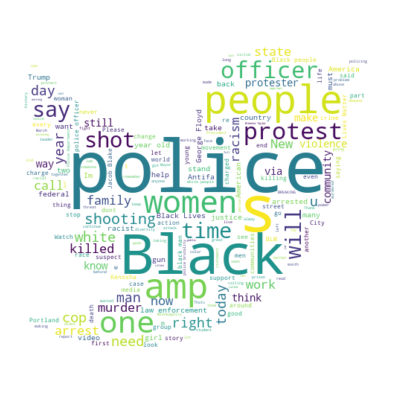

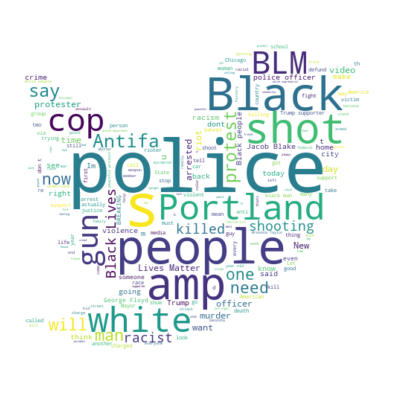

In [6]:
# Visualizing wordcloud of the racism and crime bots cluster
all_words = ' '.join([text for text in cluster_65['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110, mask=twitter_mask).generate(all_words).to_file(f'65_no_bots.png')

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Visualizing wordcloud of the racism and crime valid user cluster
all_words = ' '.join([text for text in cluster_138['tweet']])
wordcloud = WordCloud(background_color="white", width=800, height=500, random_state=21, max_font_size=110,mask=twitter_mask).generate(all_words).to_file(f'138_bots.png')

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

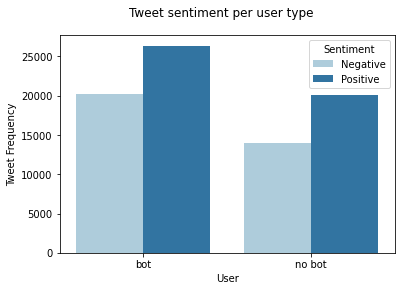

In [19]:
# Implementing barplots to show sentiment analysis for both datasets
frames = [df_bots,df_no_bots]
result = pd.concat(frames)
result = result.replace({'label':{0:'no bot', 1:'bot'}})
result = result.rename(columns={'label': 'User_type'})

hue_order = ['NEGATIVE', 'POSITIVE']
ax = sns.countplot(x='User_type', hue ='tweet_sentiment', data = result, 
                   palette='Paired', hue_order=hue_order)

ax.set_xlabel("User")
ax.set_ylabel("Tweet Frequency")
ax.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Positive'])

ax.figure.suptitle("Tweet sentiment per user type")
ax.figure.savefig('sentiment_total.png')

In [8]:
# Analysing sentiment for 5 biggest bot clusters 
print('\nPrinting Bots clusters for analysis\n--------------------------------------------------------------')
print(cluster_138.tweet_sentiment.value_counts())
print(cluster_204.tweet_sentiment.value_counts())
print(cluster_271.tweet_sentiment.value_counts())
print(cluster_200.tweet_sentiment.value_counts())
print(cluster_286.tweet_sentiment.value_counts())
print('-------------------------------------------------------\n')

# Analysing sentiment for 5 biggest valid user clusters 
print('Printing No-bots clusters for analysis \n--------------------------------------------------------------')
print(cluster_65.tweet_sentiment.value_counts())
print(cluster_137.tweet_sentiment.value_counts())
print(cluster_151.tweet_sentiment.value_counts())
print(cluster_169.tweet_sentiment.value_counts())
print(cluster_108.tweet_sentiment.value_counts())


Printing Bots clusters for analysis
--------------------------------------------------------------
NEGATIVE    1055
POSITIVE     432
Name: tweet_sentiment, dtype: int64
POSITIVE    650
NEGATIVE    289
Name: tweet_sentiment, dtype: int64
NEGATIVE    626
POSITIVE    272
Name: tweet_sentiment, dtype: int64
POSITIVE    530
NEGATIVE    324
Name: tweet_sentiment, dtype: int64
NEGATIVE    365
POSITIVE    322
Name: tweet_sentiment, dtype: int64
-------------------------------------------------------

Printing No-bots clusters for analysis 
--------------------------------------------------------------
NEGATIVE    796
POSITIVE    485
Name: tweet_sentiment, dtype: int64
NEGATIVE    436
POSITIVE    223
Name: tweet_sentiment, dtype: int64
POSITIVE    481
NEGATIVE    138
Name: tweet_sentiment, dtype: int64
POSITIVE    341
NEGATIVE    206
Name: tweet_sentiment, dtype: int64
NEGATIVE    306
POSITIVE    141
Name: tweet_sentiment, dtype: int64


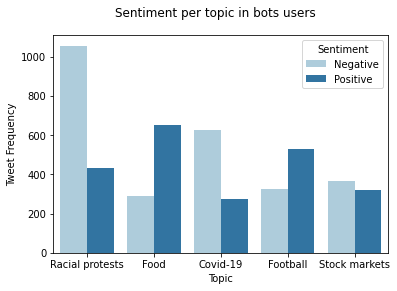

In [24]:
# Visualising the sentiment per topic for bots
frames2 = [cluster_138,cluster_204,cluster_271,cluster_200,cluster_286]
result2 = pd.concat(frames2)
result2 = result2.replace({'clustering_HDBSCAN':{138:'Racial protests', 204:'Food',
                                                 271: 'Covid-19', 200: 'Football', 286: 'Stock markets'}})

hue_order = ['NEGATIVE', 'POSITIVE']
ax = sns.countplot(x='clustering_HDBSCAN', hue ='tweet_sentiment', data = result2,
                   palette='Paired', hue_order=hue_order)

ax.set_xlabel("Topic")
ax.set_ylabel("Tweet Frequency")
ax.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Positive'])


ax.figure.suptitle("Sentiment per topic in bots users")
ax.figure.savefig('topic_sentiment_bots.png')

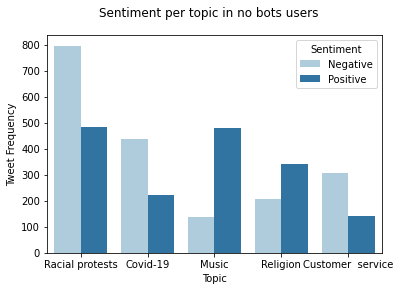

In [25]:
# Visualising the sentiment per topic for valid users
frames3 = [cluster_65,cluster_137,cluster_151,cluster_169,cluster_108]
result3 = pd.concat(frames3)
result3 = result3.replace({'clustering_HDBSCAN':{65:'Racial protests', 137: 'Covid-19',
                                                 151: 'Music', 169: 'Religion', 108: 'Customer  service'}})

hue_order = ['NEGATIVE', 'POSITIVE']
bx = sns.countplot(x='clustering_HDBSCAN', hue ='tweet_sentiment', data = result3,
                   palette="Paired", hue_order=hue_order)

bx.set_xlabel("Topic")
bx.set_ylabel("Tweet Frequency")
bx.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Positive'])


bx.figure.suptitle("Sentiment per topic in no bots users")
bx.figure.savefig('topic_sentiment_no_bots.png')

_____________